# Plot potential map estimation

__last update__: 19/01/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import time
import numpy as np
import pickle as pkl
from pprint import pprint
import matplotlib.pyplot as plt
from copy import deepcopy
import powerbox as pbox
from astropy.io import fits
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none', origin='lower')

import jax.numpy as jnp

from herculens.Instrument.psf import PSF
from herculens.LightModel.light_model import LightModel
from herculens.LensModel.lens_model import LensModel
from herculens.LensImage.lens_image import LensImage
from herculens.Util.jax_util import BicubicInterpolator as Interpolator
from herculens.Util import image_util, util, molet_util
from herculens.Util.plot_util import nice_colorbar

## Global settings

In [2]:
# Save figures on disk?
figure_dir = 'figures'
SAVE_FIGURES = True

# scale factor of the potential grid
scale_factor_potential = 4

## Load the mock data

### Coordinate grid, noise and imaging data

In [3]:
# here we load a MOLET sim just to get the coordinate grid, PSF, etc.
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/wavelet-lensing-papers/paper_II/molet'
molet_simu_name = f'molet_sim_dark_halo'

pixel_grid, noise, psf_molet, data, psi_grid_input, noise_real, _ \
    = molet_util.read_molet_simulation(molet_dir, molet_simu_name,
                                       use_true_noise_map=True, 
                                       subtract_offset=True,
                                       cut_psf=20)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")
print(f"exposure time : {noise.exposure_map} s")
print(f"background noise level : {noise.background_rms:.3f}")

# PSF
psf = PSF(psf_type='GAUSSIAN', fwhm=0.3, truncation=5, pixel_size=pix_scl)
print("PSF kernel shape:", psf.kernel_point_source.shape)

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:31: UserWarning: Using MOLET instrument 'gaussian03'.
  warnings.warn(f"Using MOLET instrument '{instrument_name}'.")
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/autodiff/jax_herculens/herculens/Util/molet_util.py:138: UserWarning: Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).
  warnings.warn("Could not prepare the 'PIXEL' PSF instance as the PSF in the instrument module is supersampled (supersampling factor?).")


image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec
exposure time : None s
background noise level : 0.071
PSF kernel shape: (19, 19)


### Mass and light models

In [4]:
# Lens mass model
kwargs_pixelated = {
    'pixel_scale_factor': scale_factor_potential,
}
lens_mass_model_input = LensModel(['SIE', 'SHEAR', 'PIXELATED'], kwargs_pixelated=kwargs_pixelated)
kwargs_macro_lens_input = {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
kwargs_ext_shear_input = {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0., 'dec_0': 0.}

# Input source model 
source_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_source_input = [
    {'amp': 76.0, 'R_sersic': 0.8, 'n_sersic': 2, 'e1': -0.09, 'e2': 0.03,
     'center_x': 0.4, 'center_y': 0.15}
]

# Input lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 133.0,
     'R_sersic': 2., 'n_sersic': 2., 
     'e1': kwargs_macro_lens_input['e1'], 'e2': kwargs_macro_lens_input['e2'], 
     'center_x': kwargs_macro_lens_input['center_x'], 'center_y': kwargs_macro_lens_input['center_y']}
]

### Image model classes, for both simulate and fit

In [5]:
kwargs_numerics = {'supersampling_factor': 1, 'convolution_type': 'grid'}

# Hybrid image model for fitting
lens_image = LensImage(pixel_grid, psf, noise_class=noise,
                       lens_model_class=lens_mass_model_input,
                       source_model_class=source_model_input,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics)

# set the values of the pixelated potential 
kwargs_pixel_pot = {'pixels': jnp.zeros(lens_image.Grid.model_pixel_shape('lens'))}
kwargs_lens_input = [kwargs_macro_lens_input, kwargs_ext_shear_input, kwargs_pixel_pot]

# group kwargs
kwargs_params = dict(kwargs_lens=kwargs_lens_input,
                     kwargs_source=kwargs_source_input,
                     kwargs_lens_light=kwargs_lens_light_input)

In [6]:
# Generate a lensed image based on source and lens models
model = lens_image.model(**kwargs_params)

# get the true source surface brightness
source_lensed = lens_image.source_surface_brightness(kwargs_source_input, 
                                                     kwargs_lens=kwargs_lens_input,
                                                     de_lensed=False, unconvolved=False)

In [7]:
# here is a copied version from the module `herculens.Util.model_util`
# that returns more than the final map to showcase the different steps of the process

def get_potential_noise_map(lens_image, kwargs_res, k_src=None, cut=1e-5):
    # data coordinates
    x_grid, y_grid = lens_image.Grid.pixel_coordinates

    # numerics grid, for intermediate computation on a higher resolution grid
    x_grid_num, y_grid_num = lens_image.ImageNumerics.coordinates_evaluate
    x_grid_num = util.array2image(x_grid_num)
    y_grid_num = util.array2image(y_grid_num)
    x_coords_num, y_coords_num = x_grid_num[0, :], y_grid_num[:, 0]
    s_0 = lens_image.SourceModel.surface_brightness(x_grid_num, y_grid_num, 
                                                    kwargs_res['kwargs_source'], 
                                                    k=k_src)
    interp_source = Interpolator(y_coords_num, x_coords_num, s_0)
    grad_s_x_srcplane = interp_source(y_grid_num, x_grid_num, dy=1)
    grad_s_y_srcplane = interp_source(y_grid_num, x_grid_num, dx=1)
    # compute its derivatives *on source plane*
    grad_s_x_srcplane = interp_source(y_grid_num, x_grid_num, dy=1)
    grad_s_y_srcplane = interp_source(y_grid_num, x_grid_num, dx=1)
    # setup the Interpolator to read on data pixels
    interp_grad_s_x = Interpolator(y_coords_num, x_coords_num, grad_s_x_srcplane)
    interp_grad_s_y = Interpolator(y_coords_num, x_coords_num, grad_s_y_srcplane)
    # use the lens equation to ray shoot the coordinates of the data grid
    x_src, y_src = lens_image.LensModel.ray_shooting(
        x_grid, y_grid, kwargs_res['kwargs_lens'])
    # evaluate the resulting arrays on that grid
    grad_s_x = interp_grad_s_x(y_src, x_src)
    grad_s_y = interp_grad_s_y(y_src, x_src)
    # proper flux units
    pixel_area = lens_image.Grid.pixel_area
    grad_s_x = np.array(grad_s_x) * pixel_area
    grad_s_y = np.array(grad_s_y) * pixel_area
    grad_s_no_conv = np.hypot(grad_s_x, grad_s_y)

    # convolve with PSF
    grad_s = lens_image.ImageNumerics.convolution_class.convolution2d(grad_s_no_conv)
    
    # the cut is to avoid NaNs or too large values to be introduced by the divide operation
    potential_noise_map_highres = np.zeros_like(grad_s)
    potential_noise_map_highres[grad_s > cut] = 1. / grad_s[grad_s > cut]
    potential_noise_map_highres[grad_s <= cut] = potential_noise_map_highres.max()

    # normalize by data noise
    model_source_only = lens_image.source_surface_brightness(kwargs_res['kwargs_source'],
                                                        kwargs_lens=kwargs_res['kwargs_lens'],
                                                        k=k_src)
    exposure_map = np.ones_like(model_source_only) * 2000.  # WARNING: here we hard code exposure time for simplicity
    C_D_model = lens_image.Noise.covariance_matrix(model_source_only, 
                                                   lens_image.Noise.background_rms, 
                                                   exposure_map)
    noise_map = np.sqrt(C_D_model)
    potential_noise_map_highres *= noise_map

    # rescaled to potential grid
    x_in, y_in = lens_image.Grid.pixel_axes
    x_out, y_out = lens_image.Grid.model_pixel_axes('lens')
    potential_noise_map = image_util.re_size_array(x_in, y_in, potential_noise_map_highres, x_out, y_out)
    return (s_0 * pixel_area, 
            np.hypot(grad_s_x_srcplane, grad_s_y_srcplane) * pixel_area,  
            grad_s_no_conv,
            grad_s,
            noise_map,
            potential_noise_map_highres,
            potential_noise_map)

In [8]:
# compute the potential noise map
source_highres, source_deriv, lensed_deriv_no_conv, lensed_deriv, sigma_d, sigma_psi_highres, sigma_psi \
    = get_potential_noise_map(lens_image, kwargs_params, cut=1e-10)

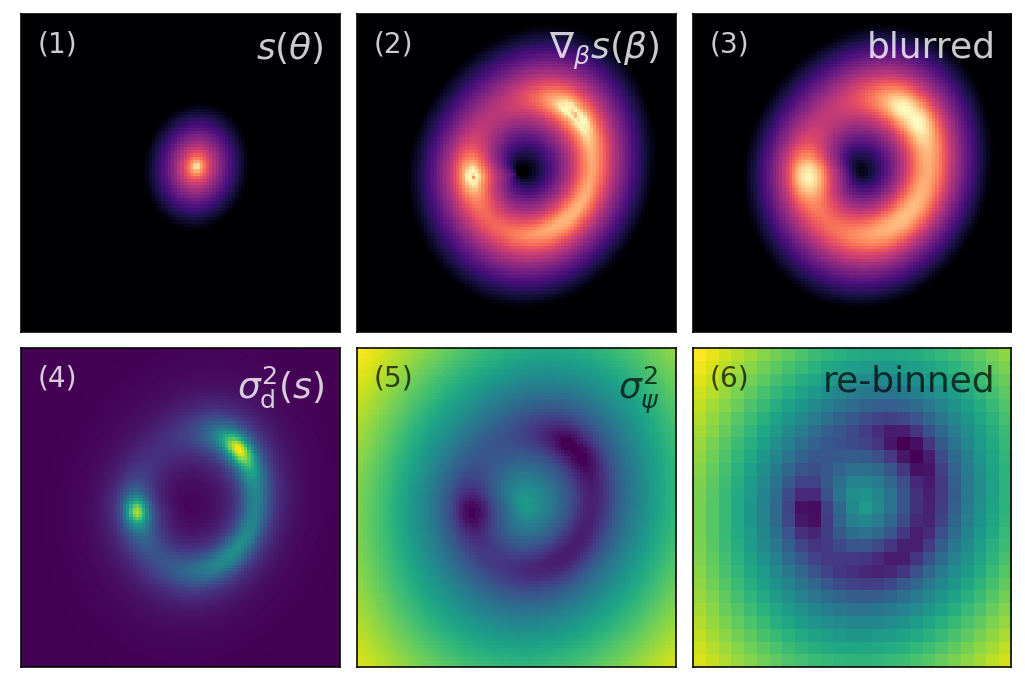

In [13]:
fontsize = 18

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
ax = axes[0, 0]
ax.text(0.05, 0.95, "(1)", ha='left', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"$s(\theta)$", ha='right', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize)
im = ax.imshow(source_highres, extent=extent, norm=LogNorm(1e-1, 1e1), cmap='magma')
im.set_rasterized(True)
#nice_colorbar(im, pad=0, fontsize=fontsize, invisible=False)

ax = axes[0, 1]
ax.text(0.05, 0.95, "(2)", ha='left', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"$\nabla_{\beta}s(\beta)$", ha='right', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize)
im = ax.imshow(lensed_deriv_no_conv, extent=extent, norm=LogNorm(1e-1), cmap='magma')
im.set_rasterized(True)

ax = axes[0, 2]
ax.text(0.05, 0.95, "(3)", ha='left', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"blurred", ha='right', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize)
im = ax.imshow(lensed_deriv, extent=extent, norm=LogNorm(1e-1), cmap='magma')
im.set_rasterized(True)

ax = axes[1, 0]
ax.text(0.05, 0.95, "(4)", ha='left', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"$\sigma^2_{\rm d}(s)$", ha='right', va='top', transform=ax.transAxes, 
        color='white', alpha=0.8, fontsize=fontsize)
im = ax.imshow(sigma_d**2, extent=extent, norm=LogNorm(), cmap='viridis')
im.set_rasterized(True)

ax = axes[1, 1]
ax.text(0.05, 0.95, "(5)", ha='left', va='top', transform=ax.transAxes, 
        color='black', alpha=0.7, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"$\sigma_\psi^2$", ha='right', va='top', transform=ax.transAxes, 
        color='black', alpha=0.7, fontsize=fontsize)
im = ax.imshow(sigma_psi_highres**2, extent=extent, norm=LogNorm(), cmap='viridis')
im.set_rasterized(True)

ax = axes[1, 2]
ax.text(0.05, 0.95, "(6)", ha='left', va='top', transform=ax.transAxes, 
        color='black', alpha=0.7, fontsize=fontsize-4)
ax.text(0.95, 0.95, r"re-binned", ha='right', va='top', transform=ax.transAxes, 
        color='black', alpha=0.7, fontsize=fontsize)
im = ax.imshow(sigma_psi**2, extent=extent, norm=LogNorm(), cmap='viridis')
im.set_rasterized(True)

fig.subplots_adjust(hspace=0.05, wspace=0.01)
plt.show()

In [14]:
if SAVE_FIGURES:
    figure_name = 'potential_noise_map_steps.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')